# Simulation 2
## FEP-based attractor network storing digits

**NOTE**: the implementation of the network is in `simulation/network.py`. This is an inefficient implementation, optimized for clarity, instead of speed.

Helper functions are in `simulation/utils.py`

### This notebook demonstrates:
- visualize setup:
    - digits
    - network architecture
- simultaneous learning and inference - parameter space and orthogonalization
    - VFE learning-curves
    - attractors: digit -> attractor  
    - orthogonality of attractors
    - recognition examples and quantification
    - 1-shot generalization examples and quantification
- demonstrate resistance to catastrophic forgetting

In [1]:
import numpy as np
from simulation.network import AttractorNetwork, Langevin, relax
from simulation.utils import fetch_digits_data, preprocess_digits_data, continous_inference_and_learning, run_network, evaluate_reconstruction_accuracy, vfe, report_network_evaluation, performance_metrics

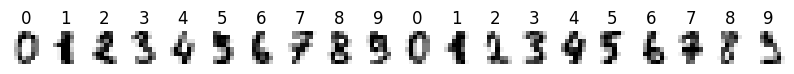

In [2]:
digits = fetch_digits_data()

### Preprocess digits
Intensities will represent evidence. We need to preprocess accordingly.
- square (make evidence higher in pixels of peak intensity)
- normalize (ensure all digits have a comparable overall evidence level)
- visualize

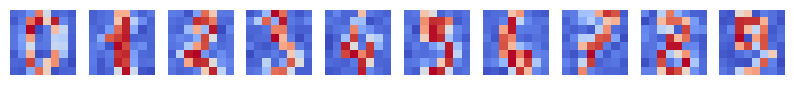

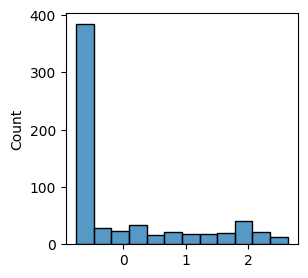

In [3]:
train_data, test_data = preprocess_digits_data(digits)

### Loop over parameters
- evidence_level: 1-20, linear
- inverse_temperature: 0.01 - 10, logarithmic

In [101]:
# Define parameter ranges
n_evidence_levels = 20 # Number of steps for evidence level (adjust as needed)
n_inverse_temperatures = 19 # Number of steps for inverse temperature (adjust as needed)
np.linspace(1, 20, num=n_evidence_levels), np.logspace(np.log10(0.01), np.log10(1), num=n_inverse_temperatures), 1/np.logspace(np.log10(0.01), np.log10(1), num=n_inverse_temperatures)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 array([0.01      , 0.0129155 , 0.01668101, 0.02154435, 0.02782559,
        0.03593814, 0.04641589, 0.05994843, 0.07742637, 0.1       ,
        0.12915497, 0.16681005, 0.21544347, 0.27825594, 0.35938137,
        0.46415888, 0.59948425, 0.77426368, 1.        ]),
 array([100.        ,  77.42636827,  59.94842503,  46.41588834,
         35.93813664,  27.82559402,  21.5443469 ,  16.68100537,
         12.91549665,  10.        ,   7.74263683,   5.9948425 ,
          4.64158883,   3.59381366,   2.7825594 ,   2.15443469,
          1.66810054,   1.29154967,   1.        ]))

### Parameter search

This will take around 30 minutes on 16 cores.

In [5]:
import numpy as np
import itertools
from joblib import Parallel, delayed
from tqdm.notebook import tqdm # For progress bar

# Define parameter ranges
n_evidence_levels = 20 # Number of steps for evidence level (adjust as needed)
n_inverse_temperatures = 19 # Number of steps for inverse temperature (adjust as needed)
evidence_levels = np.linspace(1, 20, num=n_evidence_levels)
inverse_temperatures = np.logspace(np.log10(0.01), np.log10(1), num=n_inverse_temperatures)

# Fixed parameters for the network run during search
search_learning_rate = 0.001
search_num_epochs = 5000
search_num_steps = 10

# Create parameter combinations using itertools.product
param_combinations = [{'evidence_level': ev, 'inverse_temperature': it}
                      for ev, it in itertools.product(evidence_levels, inverse_temperatures)]

print(f"Starting parameter search for {len(param_combinations)} combinations...")
print(f"Evidence levels: {np.round(evidence_levels, 3)}")
print(f"Inverse temperatures: {np.round(inverse_temperatures, 3)}")

# Define the wrapper function to be called by joblib.
# This function takes one parameter combination dict and runs the simulation.
import warnings

def run_network_wrapper(params):
    """
    Runs the AttractorNetwork simulation for a given set of parameters.
    Assumes 'train_data' and 'run_network' are available in the execution scope.
    """
    # run_network is imported in cell 2
       # train_data is defined in cell 5
    training_output = run_network(
            data=train_data,
            evidence_level=params['evidence_level'],
            inverse_temperature=params['inverse_temperature'],
            learning_rate=search_learning_rate,
            num_epochs=search_num_epochs,
            num_steps=search_num_steps,
            progress_bar=False # Suppress progress bars within parallel runs
    )

    # Return the parameters and the output (network state, attractors, history)
    return {'params': params,
            'nw': training_output[0],
            'training_output': training_output,
            }

print(f"Running {len(param_combinations)} simulations in parallel...")
results = Parallel(n_jobs=-1)(
    delayed(run_network_wrapper)(params) for params in param_combinations
)

print(f"\nParameter search completed. Collected {len(results)} results.")

Starting parameter search for 380 combinations...
Evidence levels: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
Inverse temperatures: [0.01  0.013 0.017 0.022 0.028 0.036 0.046 0.06  0.077 0.1   0.129 0.167
 0.215 0.278 0.359 0.464 0.599 0.774 1.   ]
Running 380 simulations in parallel...



Parameter search completed. Collected 380 results.


In [6]:
import pickle

# Save the results to a file
results_filename = 'parameter_search_results.pkl'
try:
    with open(results_filename, 'wb') as f:
        pickle.dump(results, f)
    print(f"Results successfully saved to {results_filename}")
except Exception as e:
    print(f"Error saving results: {e}")

# Optionally, load the results back to verify (or use in a later session)
# try:
#     with open(results_filename, 'rb') as f:
#         loaded_results = pickle.load(f)
#     print(f"Results successfully loaded from {results_filename}")
#     # You can now use loaded_results instead of results if needed
# except Exception as e:
#     print(f"Error loading results: {e}")


Results successfully saved to parameter_search_results.pkl


In [96]:

def run_performance_metrics_wrapper(input_dict):
    """
    Runs the AttractorNetwork simulation for a given set of parameters.
    Assumes 'train_data' and 'run_network' are available in the execution scope.
    """
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='Mean of empty slice.')
        warnings.filterwarnings('ignore', message='invalid value encountered in scalar divide')
        warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in divide')

        median_delta_r2_retrieval, median_delta_r2_generalization, num_attractors, orthogonality_data, orthogonality_attractors = performance_metrics(
            training_output = input_dict['training_output'],
            train_data = train_data,
            test_data = test_data,
            evidence_level=input_dict['params']['evidence_level'],
            params_retreival={
                                    "num_trials": 100,
                                    "num_steps": 100,
                                    "signal_strength": 0.1,
                                    "SNR": 1,
                                    "inverse_temperature": 1,
                              },
                              params_generalization={
                                    "num_trials": 100,
                                    "num_steps": 100,
                                    "signal_strength": 0.1,
                                    "SNR": 1,
                                    "inverse_temperature": 1,
                              },
            inverse_temperature_deterministic = 1)
        
    return {
        'params': input_dict['params'],
        'nw': input_dict['nw'],
        'median_delta_r2_retrieval': median_delta_r2_retrieval,
        'median_delta_r2_generalization': median_delta_r2_generalization,
        'num_attractors': num_attractors,
        'orthogonality_data': orthogonality_data,
        'orthogonality_attractors': orthogonality_attractors,
    }


print(f"Running {len(param_combinations)} performance estimations in parallel...")
performance_results = Parallel(n_jobs=-1)(
    delayed(run_performance_metrics_wrapper)(input_dict) for input_dict in results
)

print(f"\nPerformance metrics estimation completed.")

Running 380 performance estimations in parallel...

Performance metrics estimation completed.


In [97]:
import pickle

# Define the filename for saving the results
results_filename = 'performance_results.pkl'

# Save the results list to a file using pickle
try:
    with open(results_filename, 'wb') as f:
        pickle.dump(results, f)
    print(f"Performance results successfully saved to {results_filename}")
except Exception as e:
    print(f"Error saving performance results: {e}")

# Optionally, load the results back to verify (or for later use)
# try:
#     with open(results_filename, 'rb') as f:
#         loaded_results = pickle.load(f)
#     print(f"Successfully loaded results from {results_filename}")
#     # You can add a check here, e.g., comparing len(results) and len(loaded_results)
# except Exception as e:
#     print(f"Error loading performance results: {e}")


Performance results successfully saved to performance_results.pkl


## Heatmaps

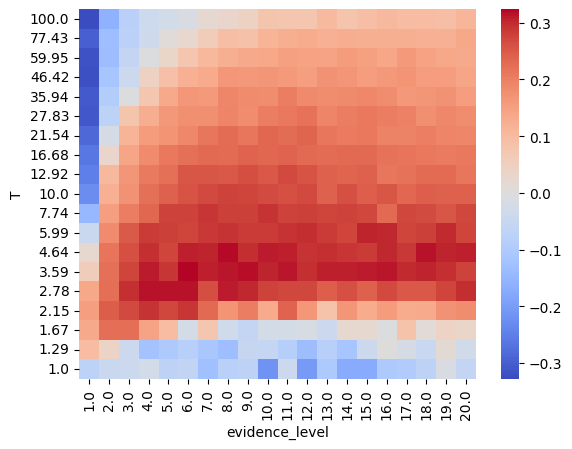

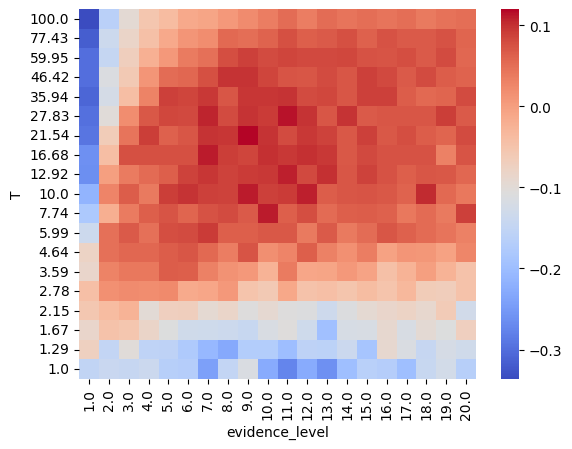

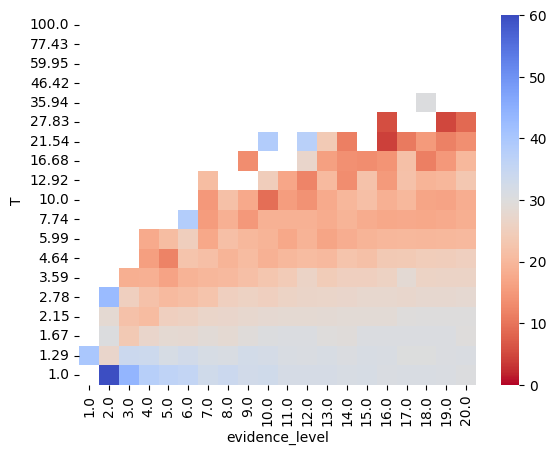

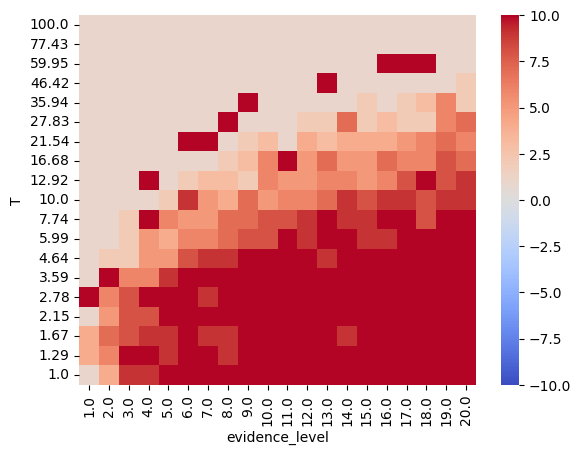

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

data_list = []
for res in performance_results:
    # Check if the result dictionary has the expected keys
    if ('params' in res and
        'median_delta_r2_generalization' in res and
        'median_delta_r2_retrieval' in res and
        'orthogonality_data' in res and
        'orthogonality_attractors' in res and
        'evidence_level' in res['params'] and
        'inverse_temperature' in res['params']):
        data_list.append({
            'evidence_level': res['params']['evidence_level'],
            'inverse_temperature': res['params']['inverse_temperature'],
            'generalization': res['median_delta_r2_generalization'],
            'retrieval': res['median_delta_r2_retrieval'],
            'orthogonality_data': res['orthogonality_data'],
            'orthogonality_attractors': res['orthogonality_attractors'],
            'num_attractors': res['num_attractors']
        })
    else:
        print(f"Skipping result due to missing keys: {res.get('params', 'Params Missing')}")


if not data_list:
    print("No valid results found to plot.")
else:
    df = pd.DataFrame(data_list)
    df['inverse_temperature'] = df['inverse_temperature']

df['T'] = (1/df['inverse_temperature']).round(2)

df.loc[df['num_attractors'] == 1, 'orthogonality_attractors'] = np.nan

import seaborn as sns
pivot_df = df.pivot(index='evidence_level', columns='T', values='retrieval')
pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
sns.heatmap(pivot_df.transpose(), cmap='coolwarm', annot=False, fmt='.2f')
plt.show()

pivot_df = df.pivot(index='evidence_level', columns='T', values='generalization')
pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
sns.heatmap(pivot_df.transpose(), cmap='coolwarm', annot=False, fmt='.2f')
plt.show()

pivot_df = df.pivot(index='evidence_level', columns='T', values='orthogonality_attractors')
pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
sns.heatmap(pivot_df.transpose(), cmap='coolwarm_r', vmin=0, vmax=60, annot=False, fmt='.2f')
plt.show()

pivot_df = df.pivot(index='evidence_level', columns='T', values='num_attractors')
pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
sns.heatmap(pivot_df.transpose(), cmap='coolwarm', vmin=-10, vmax=10, annot=False, fmt='.2f')
plt.show()

## Contour plots

In [121]:
np.linspace(-0.33, 0.33, 11)

array([-0.33 , -0.264, -0.198, -0.132, -0.066,  0.   ,  0.066,  0.132,
        0.198,  0.264,  0.33 ])

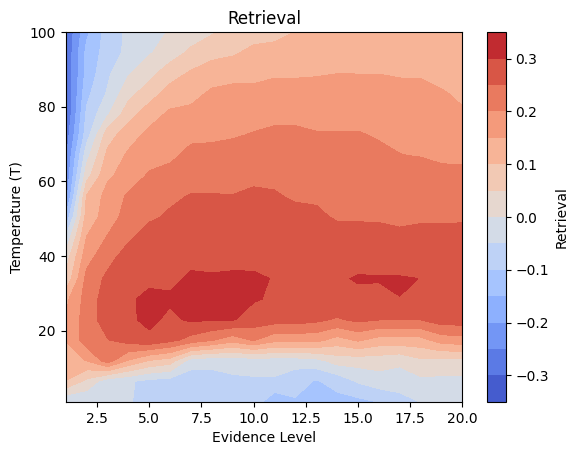

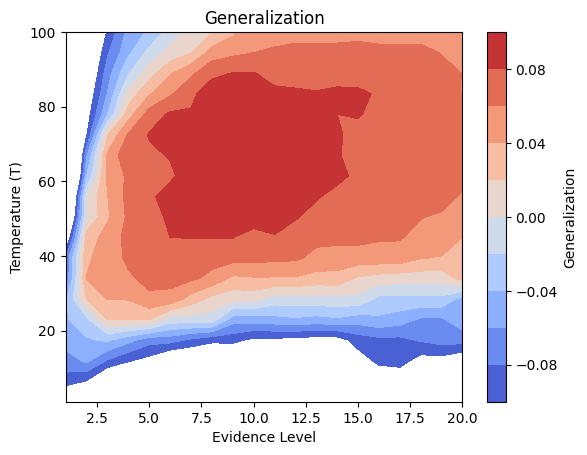

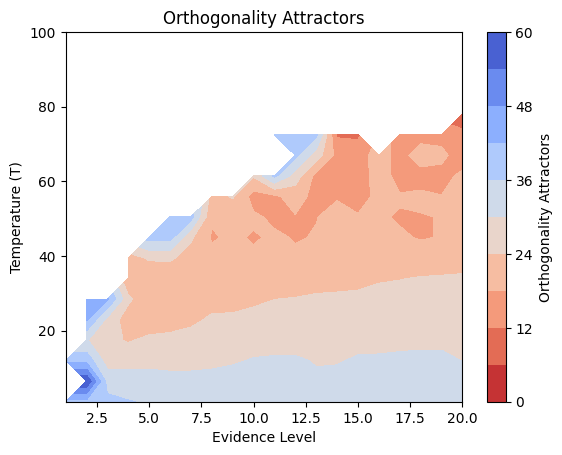

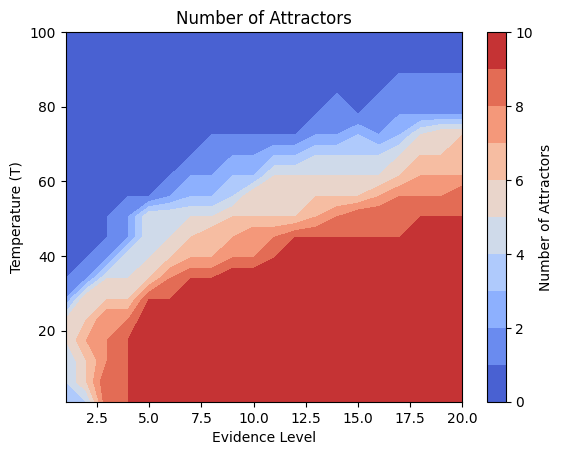

In [131]:
import seaborn as sns
from scipy.ndimage import median_filter # Changed from gaussian_filter
import numpy as np
import matplotlib.pyplot as plt

# Define median filter size
filter_size = 3 # Size 1 means no filtering. Use size > 1 (e.g., 3) for smoothing.

# Retrieval
pivot_df = df.pivot(index='evidence_level', columns='T', values='retrieval')
pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
data_to_plot = pivot_df.transpose()
x = np.linspace(1, 20, num=n_evidence_levels)#data_to_plot.columns.values # evidence_level
y = np.linspace(100, 1, num=n_inverse_temperatures)#data_to_plot.index.values   # T
z = data_to_plot.values         # retrieval
# Apply median filter
z_filtered = median_filter(z, size=filter_size) # Changed from gaussian_filter
# Create meshgrid for contourf
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, z_filtered, cmap='coolwarm', levels=np.linspace(-0.35, 0.35, 15)) # levels can be adjusted
plt.colorbar(label='Retrieval')
plt.xlabel('Evidence Level')
plt.ylabel('Temperature (T)')
plt.title('Retrieval') # Removed (Smoothed)
plt.show()

# Generalization
pivot_df_gen = df.pivot(index='evidence_level', columns='T', values='generalization')
pivot_df_gen = pivot_df_gen.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
data_to_plot_gen = pivot_df_gen.transpose()
z_gen = data_to_plot_gen.values         # generalization
# Apply median filter
z_gen_filtered = median_filter(z_gen, size=filter_size) # Changed from gaussian_filter
plt.contourf(X, Y, z_gen_filtered, cmap='coolwarm', levels=np.linspace(-0.1, 0.1, 11)) # levels can be adjusted
plt.colorbar(label='Generalization')
plt.xlabel('Evidence Level')
plt.ylabel('Temperature (T)')
plt.title('Generalization') # Removed (Smoothed)
plt.show()

# Orthogonality Attractors
pivot_df_ortho = df.pivot(index='evidence_level', columns='T', values='orthogonality_attractors')
pivot_df_ortho = pivot_df_ortho.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
data_to_plot_ortho = pivot_df_ortho.transpose()
z_ortho = data_to_plot_ortho.values         # orthogonality_attractors
# Handle potential NaNs before filtering
# Calculate median excluding NaNs, handle case where all are NaN
valid_ortho = z_ortho[~np.isnan(z_ortho)]
#median_val = np.median(valid_ortho) if valid_ortho.size > 0 else 0 # Use 0 if all are NaN
#z_ortho_filled = np.nan_to_num(z_ortho, nan=median_val)
# Apply median filter
z_ortho_filtered = median_filter(z_ortho, size=filter_size, mode='nearest') # Changed from gaussian_filter
# Put back NaNs where they originally were
#z_ortho_filtered = np.where(np.isnan(z_ortho), np.nan, z_ortho_filtered) # More robust way to put NaNs back

plt.contourf(X, Y, z_ortho_filtered, cmap='coolwarm_r', levels=np.linspace(0, 60, 11)) # levels can be adjusted, using settings from heatmap
plt.colorbar(label='Orthogonality Attractors')
plt.xlabel('Evidence Level')
plt.ylabel('Temperature (T)')
plt.title('Orthogonality Attractors') # Removed (Smoothed)
plt.show()

# Number of Attractors
pivot_df_num = df.pivot(index='evidence_level', columns='T', values='num_attractors')
pivot_df_num = pivot_df_num.sort_index(axis=0).sort_index(axis=1, ascending=False) # Ensure sorting
data_to_plot_num = pivot_df_num.transpose()
z_num = data_to_plot_num.values         # num_attractors
# Handle potential NaNs before filtering (though less likely here)
z_num_filled = np.nan_to_num(z_num, nan=0.0) # Replace NaN with 0
# Apply median filter
z_num_filtered = median_filter(z_num_filled, size=filter_size) # Changed from gaussian_filter
# Note: NaNs are not restored here, consistent with previous logic

plt.contourf(X, Y, z_num_filtered, cmap='coolwarm', levels=np.linspace(0, 10, 11)) # levels can be adjusted, using settings from heatmap
plt.colorbar(label='Number of Attractors')
plt.xlabel('Evidence Level')
plt.ylabel('Temperature (T)')
plt.title('Number of Attractors') # Removed (Smoothed)
plt.show()


## Balanced complexity

{'params': {'evidence_level': np.float64(11.0), 'inverse_temperature': np.float64(0.16681005372000582)}, 'nw': <simulation.network.AttractorNetwork object at 0x61605c410>, 'median_delta_r2_retrieval': np.float64(0.292), 'median_delta_r2_generalization': np.float64(0.07), 'num_attractors': 10, 'orthogonality_data': np.float64(29.9374356124914), 'orthogonality_attractors': np.float64(17.34285659875748)}
* Visualize training data


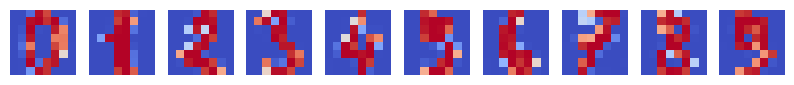

* Network weights (Evidence: 11, iT: 0.1668)


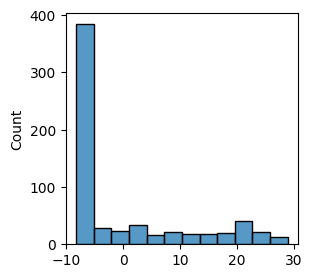

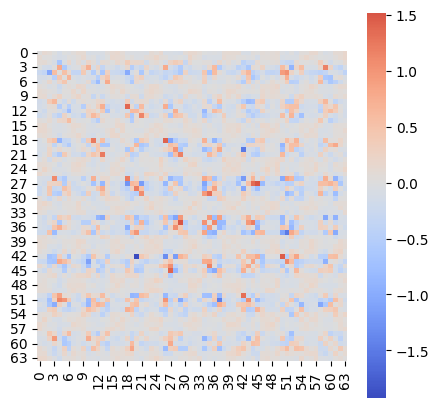

* Weight change (Evidence: 11, iT: 0.1668)


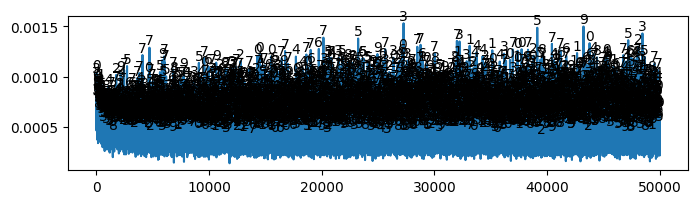

* Accuracy (Evidence: 11, iT: 0.1668)


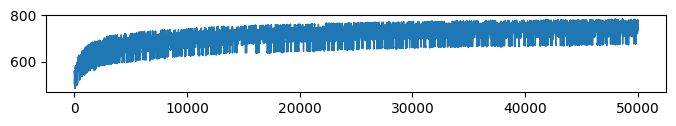

* Complexity (Evidence: 11, iT: 0.1668)


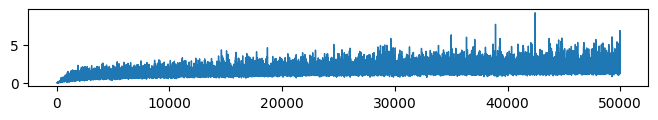

* VFE (Evidence: 11, iT: 0.1668)


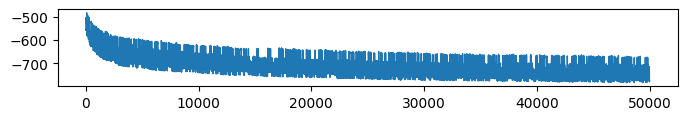

* Retrieval accuracy (Evidence: 11, iT: 0.1668)


100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


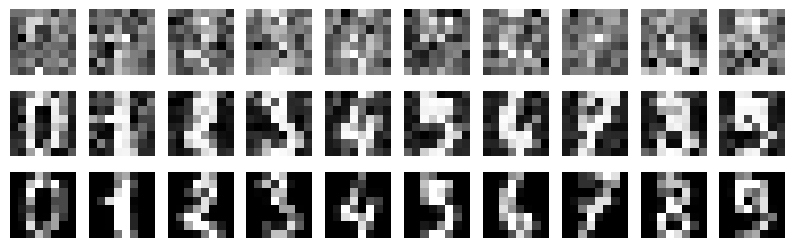

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


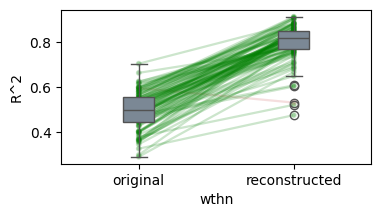

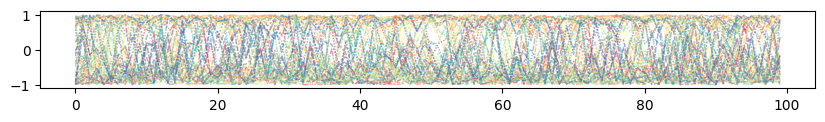

* Generalization accuracy (Evidence: 11, iT: 0.1668)


100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


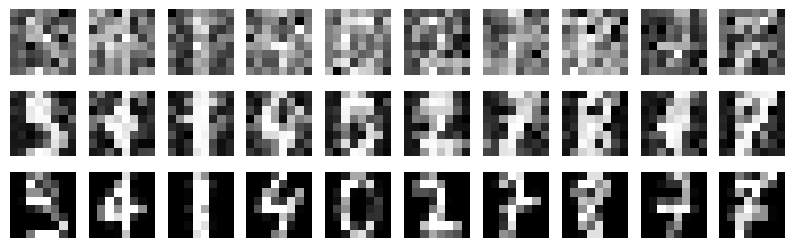

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


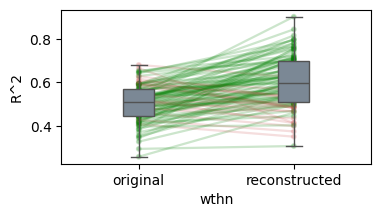

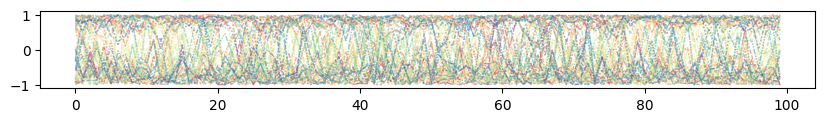

* Attractors
  ** Noise: 0.0


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


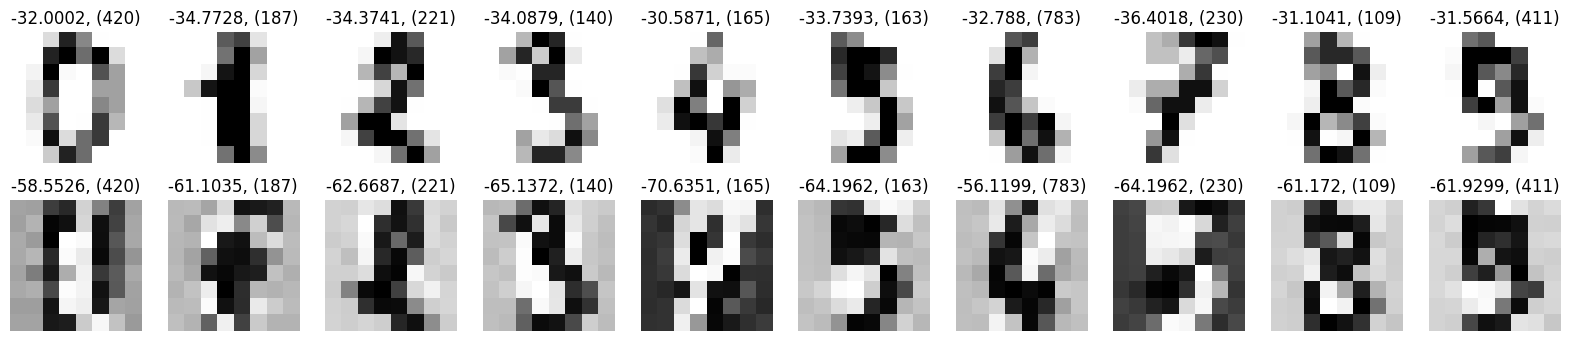

  ** Noise: 0.5


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


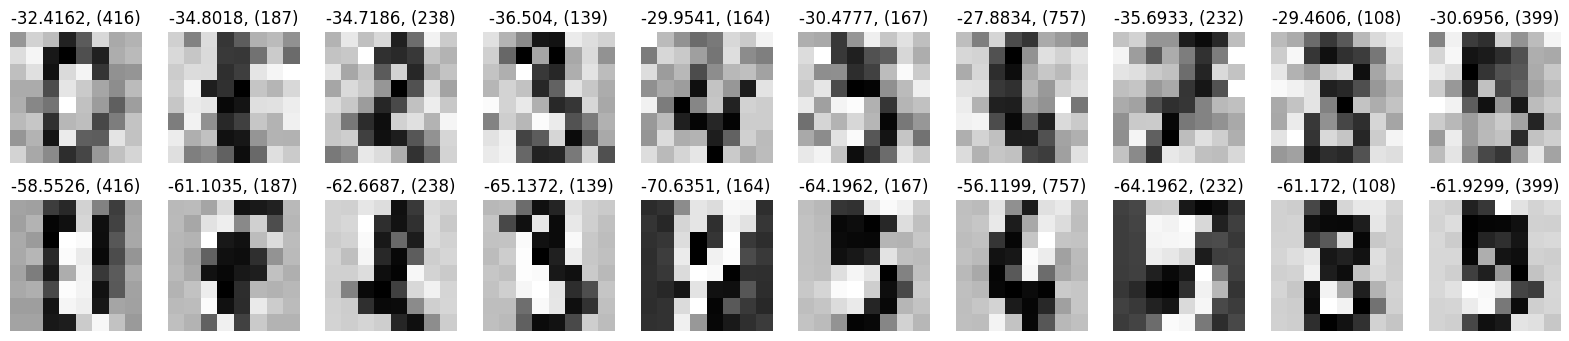

* Orthogonality


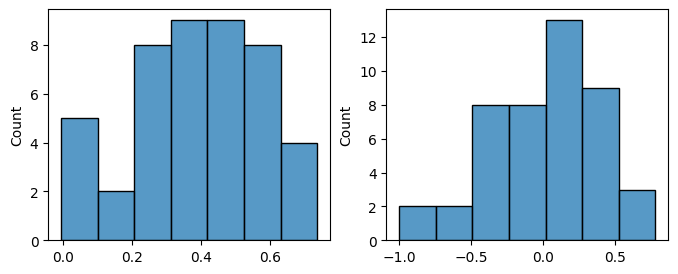

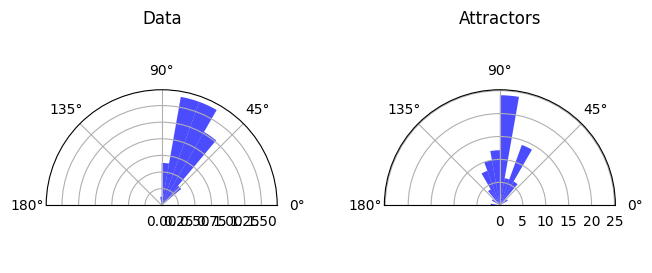

In [135]:
evidence_level = 11
inverse_temperature = 0.1668

# Find the entry in performance_results that matches the specified evidence_level and inverse_temperature
matching_entry = None
for i, entry in enumerate(performance_results):
    # Use np.isclose for floating point comparison
    if np.isclose(entry['params']['evidence_level'], evidence_level, rtol=0.01) and \
       np.isclose(entry['params']['inverse_temperature'], inverse_temperature, rtol=0.01):
        matching_entry = entry
        break

print(matching_entry)

report_network_evaluation(results[i]['training_output'],
                          train_data=train_data,
                          test_data=test_data,
                          evidence_level=matching_entry['params']['evidence_level'],
                          params_retreival={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.1,
                                "SNR": 1,
                                "inverse_temperature": 1,
                          },
                          params_generalization={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.1,
                                "SNR": 1,
                                "inverse_temperature": 1,
                          },
                          inverse_temperature_deterministic = 1,
                          title=f"Evidence: {evidence_level}, iT: {inverse_temperature}")

## High complexity - accuracy pumping

{'params': {'evidence_level': np.float64(16.0), 'inverse_temperature': np.float64(0.3593813663804626)}, 'nw': <simulation.network.AttractorNetwork object at 0x642025e50>, 'median_delta_r2_retrieval': np.float64(0.27), 'median_delta_r2_generalization': np.float64(-0.05050000000000002), 'num_attractors': 10, 'orthogonality_data': np.float64(29.9374356124914), 'orthogonality_attractors': np.float64(27.571865380432584)}
* Visualize training data


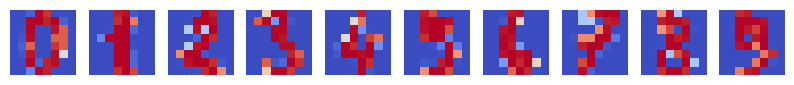

* Network weights (Evidence: 16, iT: 0.35938)


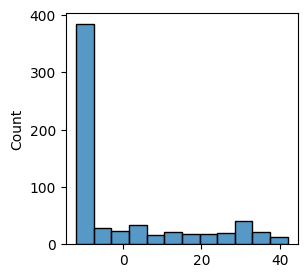

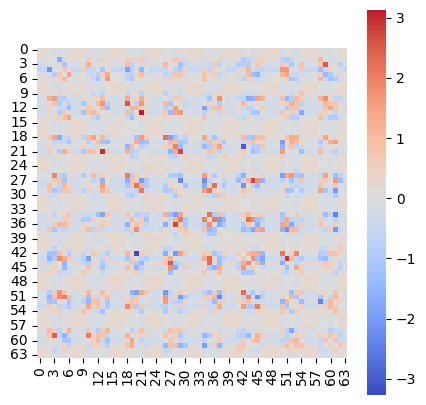

* Weight change (Evidence: 16, iT: 0.35938)


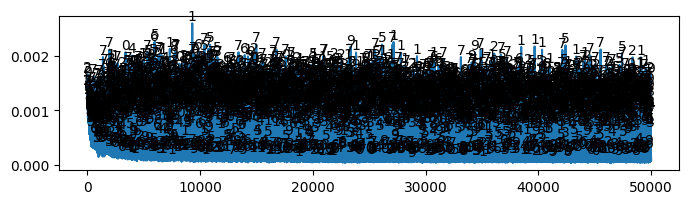

* Accuracy (Evidence: 16, iT: 0.35938)


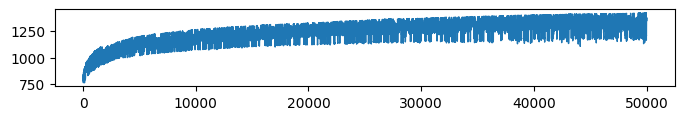

* Complexity (Evidence: 16, iT: 0.35938)


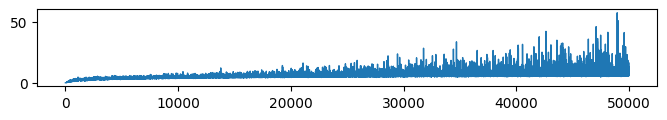

* VFE (Evidence: 16, iT: 0.35938)


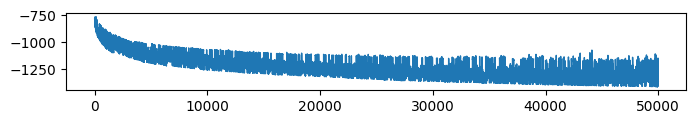

* Retrieval accuracy (Evidence: 16, iT: 0.35938)


100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


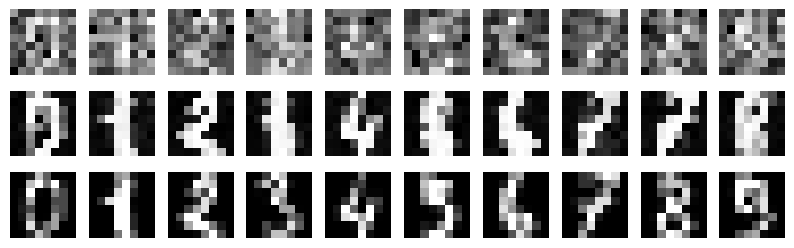

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


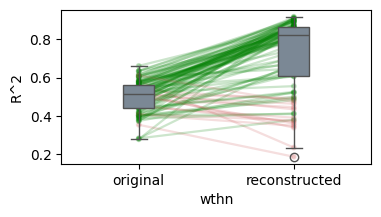

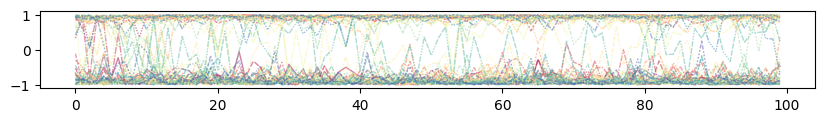

* Generalization accuracy (Evidence: 16, iT: 0.35938)


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]


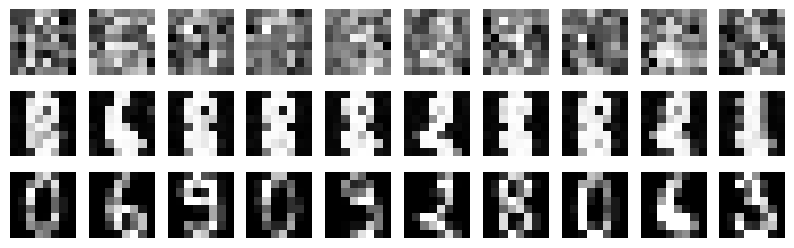

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


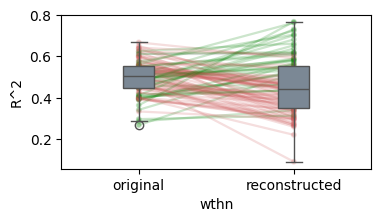

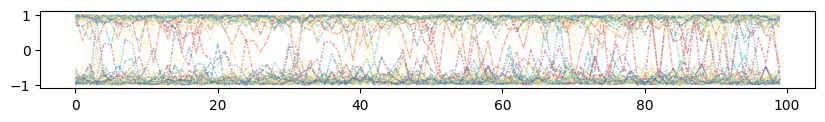

* Attractors
  ** Noise: 0.0


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


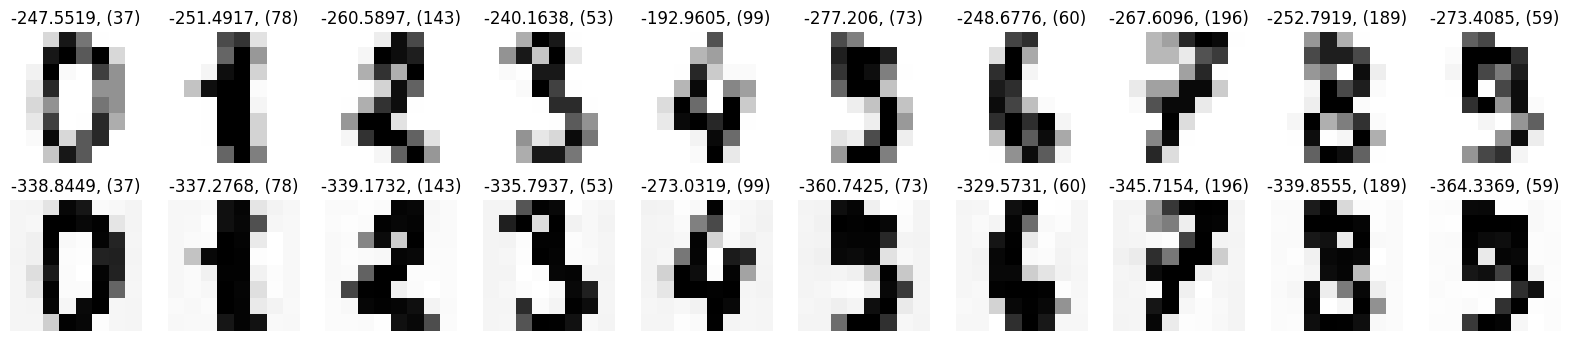

  ** Noise: 0.5


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


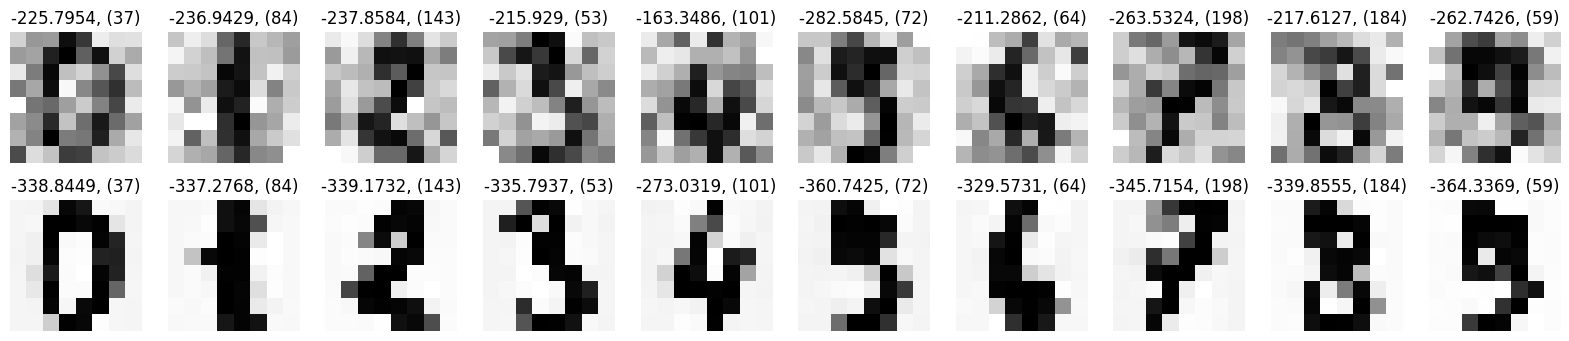

* Orthogonality


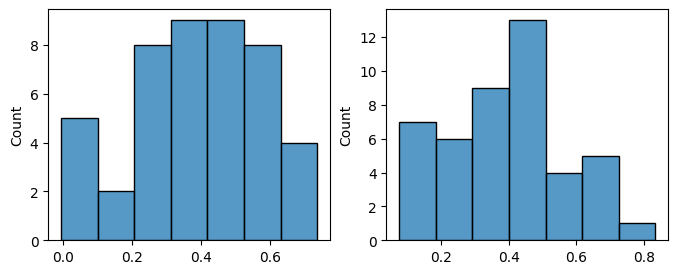

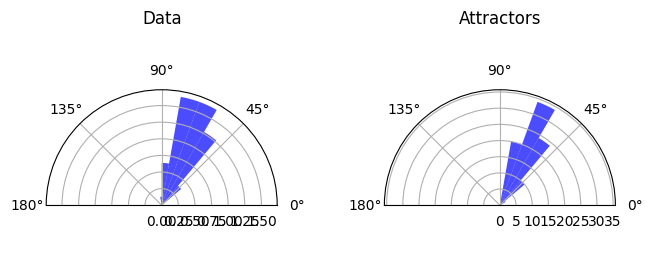

In [134]:
evidence_level = 16
inverse_temperature = 0.35938 # 2.78

# Find the entry in performance_results that matches the specified evidence_level and inverse_temperature
matching_entry = None
for i, entry in enumerate(performance_results):
    # Use np.isclose for floating point comparison
    if np.isclose(entry['params']['evidence_level'], evidence_level, rtol=0.01) and \
       np.isclose(entry['params']['inverse_temperature'], inverse_temperature, rtol=0.01):
        matching_entry = entry
        break

print(matching_entry)

report_network_evaluation(results[i]['training_output'],
                          train_data=train_data,
                          test_data=test_data,
                          evidence_level=matching_entry['params']['evidence_level'],
                          params_retreival={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.1,
                                "SNR": 1,
                                "inverse_temperature": 1,
                          },
                          params_generalization={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.1,
                                "SNR": 1,
                                "inverse_temperature": 1,
                          },
                          inverse_temperature_deterministic = 1,
                          title=f"Evidence: {evidence_level}, iT: {inverse_temperature}")

## Low complexity - oversimplified

{'params': {'evidence_level': np.float64(6.0), 'inverse_temperature': np.float64(0.027825594022071243)}, 'nw': <simulation.network.AttractorNetwork object at 0x817d9f350>, 'median_delta_r2_retrieval': np.float64(0.16449999999999998), 'median_delta_r2_generalization': np.float64(0.08450000000000002), 'num_attractors': 1, 'orthogonality_data': np.float64(29.937435612491395), 'orthogonality_attractors': np.float64(nan)}
* Visualize training data


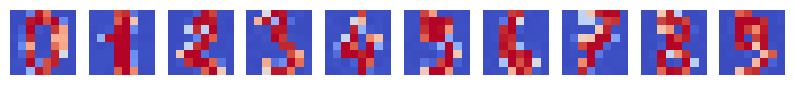

* Network weights (Evidence: 6, iT: 0.02782559)


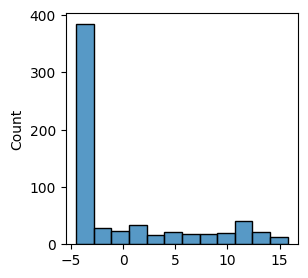

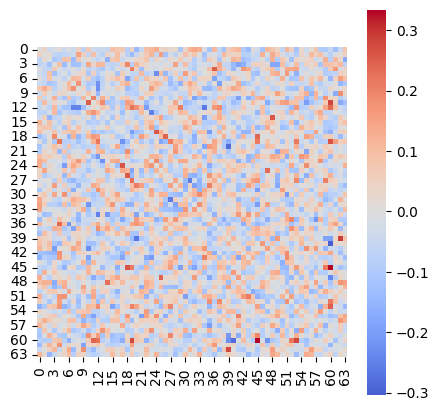

* Weight change (Evidence: 6, iT: 0.02782559)


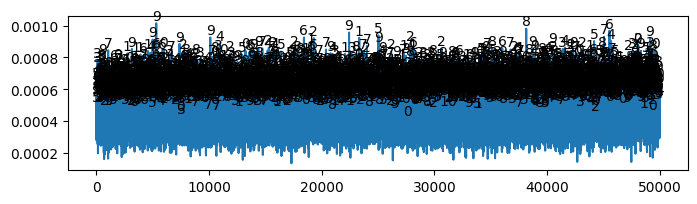

* Accuracy (Evidence: 6, iT: 0.02782559)


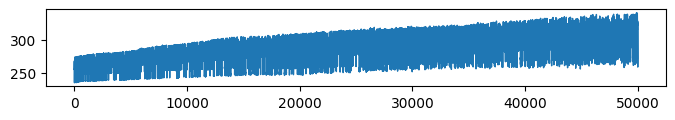

* Complexity (Evidence: 6, iT: 0.02782559)


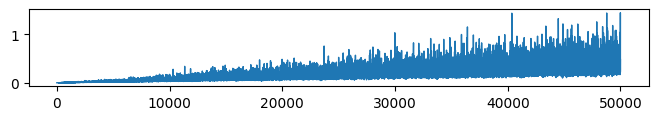

* VFE (Evidence: 6, iT: 0.02782559)


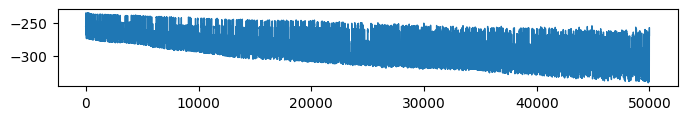

* Retrieval accuracy (Evidence: 6, iT: 0.02782559)


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


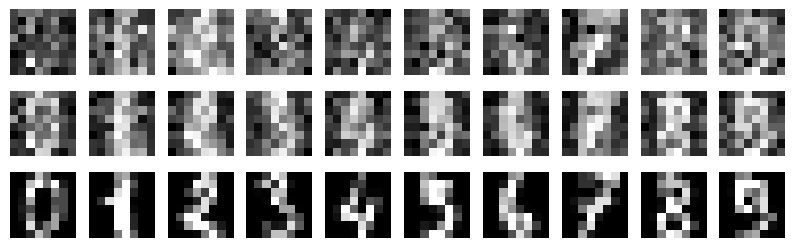

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


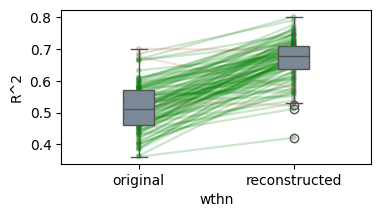

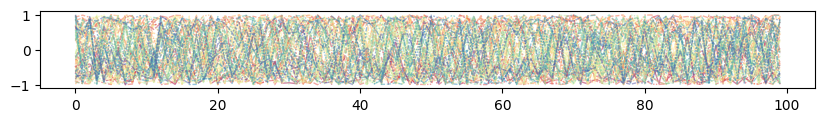

* Generalization accuracy (Evidence: 6, iT: 0.02782559)


100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


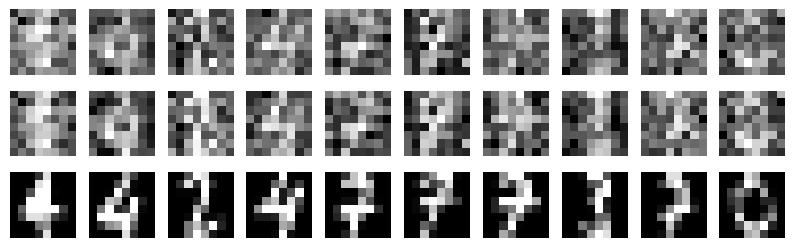

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


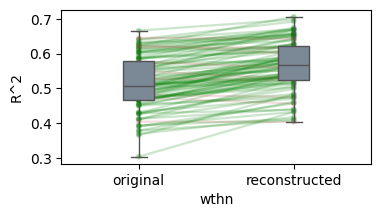

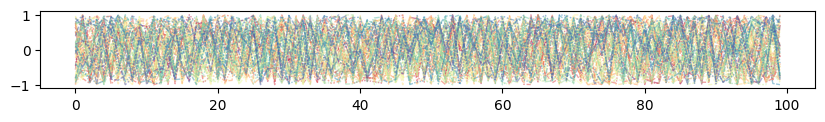

* Attractors
  ** Noise: 0.0


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


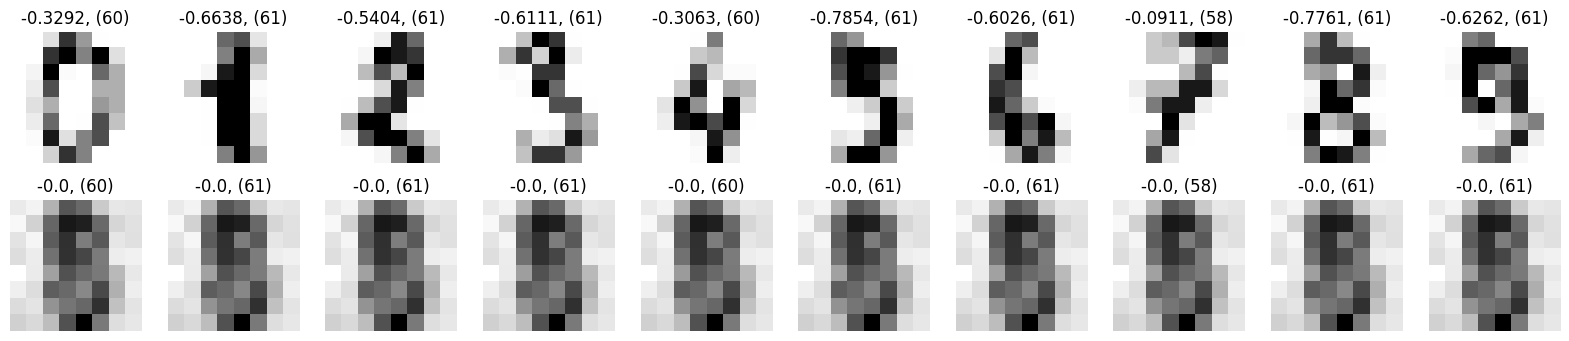

  ** Noise: 0.5


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


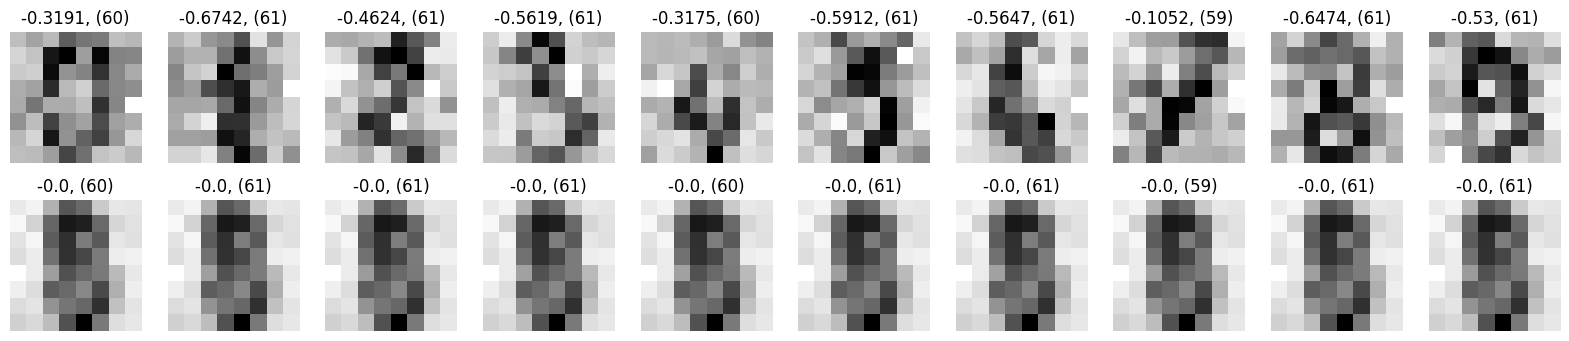

* Orthogonality


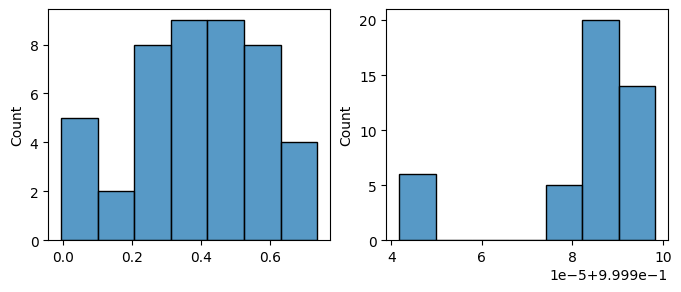

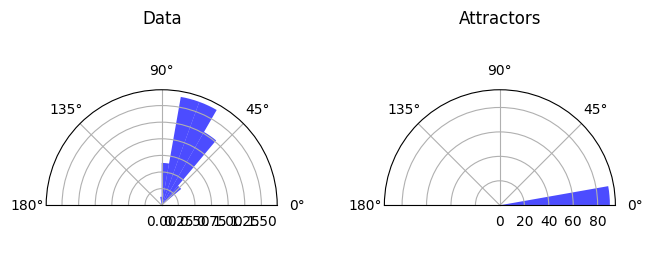

In [136]:
evidence_level = 6
inverse_temperature = 0.02782559 # 35.94

# Find the entry in performance_results that matches the specified evidence_level and inverse_temperature
matching_entry = None
for i, entry in enumerate(performance_results):
    # Use np.isclose for floating point comparison
    if np.isclose(entry['params']['evidence_level'], evidence_level, rtol=0.01) and \
       np.isclose(entry['params']['inverse_temperature'], inverse_temperature, rtol=0.01):
        matching_entry = entry
        break

print(matching_entry)

report_network_evaluation(results[i]['training_output'],
                          train_data=train_data,
                          test_data=test_data,
                          evidence_level=matching_entry['params']['evidence_level'],
                          params_retreival={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.1,
                                "SNR": 1,
                                "inverse_temperature": 1,
                          },
                          params_generalization={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.2,
                                "SNR": 1,
                                "inverse_temperature": 0.5,
                          },
                          inverse_temperature_deterministic = 1,
                          title=f"Evidence: {evidence_level}, iT: {inverse_temperature}")

## Illustrate resistance to catastrophic forgetting

{'params': {'evidence_level': np.float64(11.0), 'inverse_temperature': np.float64(0.16681005372000582)}, 'nw': <simulation.network.AttractorNetwork object at 0x61605c410>, 'median_delta_r2_retrieval': np.float64(0.292), 'median_delta_r2_generalization': np.float64(0.07), 'num_attractors': 10, 'orthogonality_data': np.float64(29.9374356124914), 'orthogonality_attractors': np.float64(17.34285659875748)}


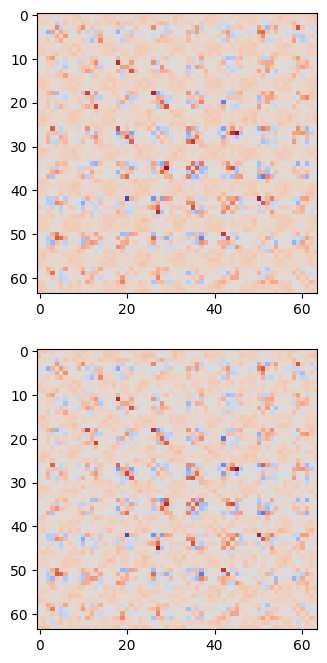

In [174]:
from simulation.utils import continous_inference_and_learning
from copy import deepcopy

evidence_level = 11
inverse_temperature = 0.1668

# Find the entry in performance_results that matches the specified evidence_level and inverse_temperature
matching_entry = None
for i, entry in enumerate(performance_results):
    # Use np.isclose for floating point comparison
    if np.isclose(entry['params']['evidence_level'], evidence_level, rtol=0.01) and \
       np.isclose(entry['params']['inverse_temperature'], inverse_temperature, rtol=0.01):
        matching_entry = entry
        break

print(matching_entry)

training_output_modified = deepcopy(results[i]['training_output'])

nw = deepcopy(matching_entry['nw'])

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].imshow(nw.get_J(), cmap='coolwarm')


num_steps = 50000 # just like during training
learning_rate = 0.001 # just like during training
inverse_temperature = 1 # increased

for i in range(num_steps): #keep on running with zero bias
    nw.update(inverse_temperature=inverse_temperature, learning_rate=learning_rate, least_action=False)

axs[1].imshow(nw.get_J(), cmap='coolwarm')

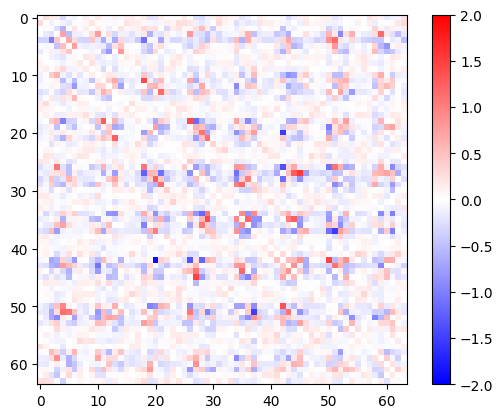

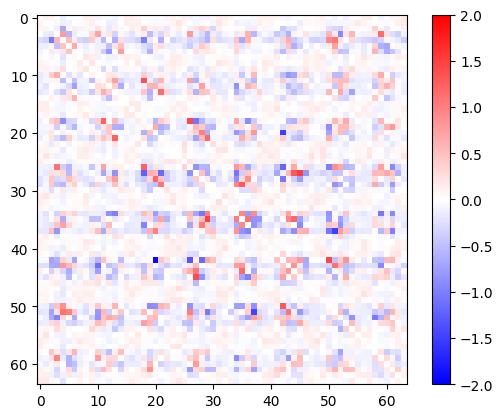

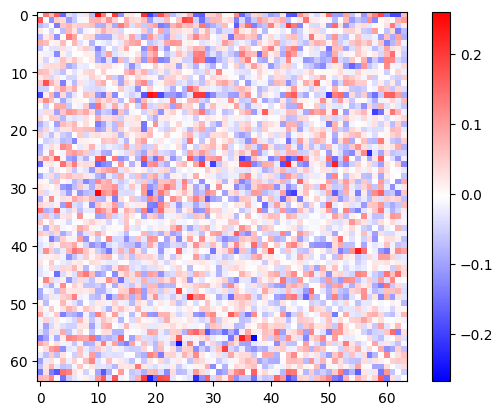

In [175]:
plt.imshow(nw.get_J(), cmap='bwr', vmin=-2, vmax=2)
plt.colorbar()
plt.show()

plt.imshow(matching_entry['nw'].get_J(), cmap='bwr', vmin=-2, vmax=2)
plt.colorbar()
plt.show()

plt.imshow(nw.get_J()-matching_entry['nw'].get_J(), cmap='bwr',)
plt.colorbar()
plt.show()


  ** Noise: 0













100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


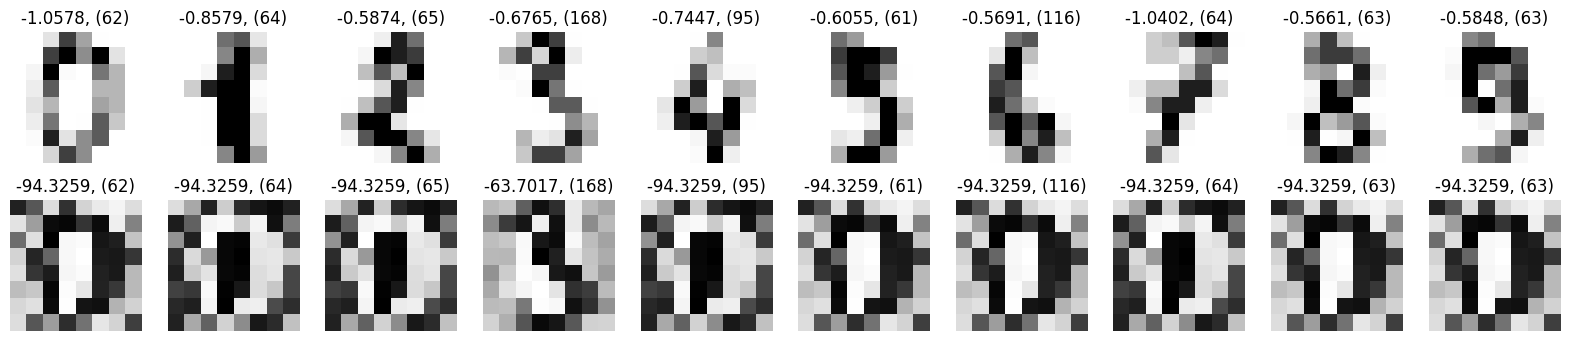

[array([ 0.65669753,  0.29384145, -0.62176981,  0.54847903, -0.55720076,
        -0.71607635, -0.78333143, -0.62448424, -0.66615224, -0.19466426,
         0.81260351,  0.84679351,  0.53095615,  0.81321903, -0.74901719,
        -0.00254631,  0.14248094, -0.63873446,  0.89203682, -0.81326769,
        -0.83501304,  0.73809967,  0.67386437, -0.453668  , -0.56128001,
         0.63136854,  0.18989576, -0.81373973, -0.86418984,  0.70176772,
         0.72515506,  0.51643672, -0.65005424,  0.52789558,  0.69380874,
        -0.80207235, -0.83510363,  0.65613875,  0.70695724, -0.37955574,
        -0.40627066, -0.47810675,  0.84466697, -0.83676496, -0.69163255,
         0.64657621,  0.50238512, -0.38214439, -0.58690001, -0.65018608,
         0.81446708, -0.85377067,  0.75427862,  0.77924567, -0.34835191,
        -0.55434745, -0.62741159,  0.29655652, -0.18958975,  0.58090802,
         0.10000736, -0.69236451, -0.56507816,  0.46354485]),
 array([-0.65669753, -0.29384145,  0.62176981, -0.54847903,  0

In [176]:
from simulation.utils import get_deterministic_attractors

get_deterministic_attractors(nw=nw, data=train_data, noise_levels=[0], inverse_temperature=1)

* Visualize training data


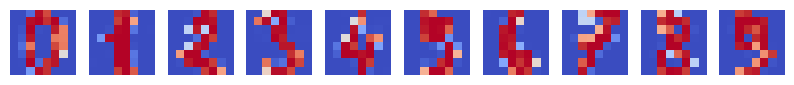

* Network weights (Evidence: 11, iT: 1)


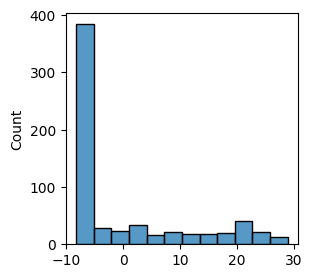

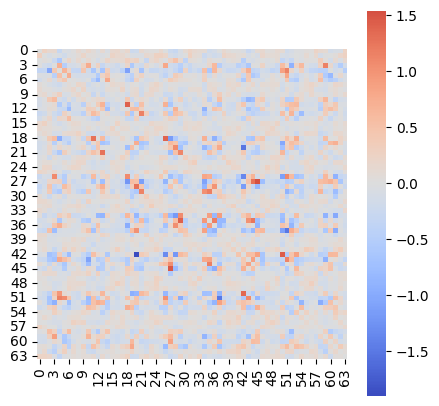

* Weight change (Evidence: 11, iT: 1)


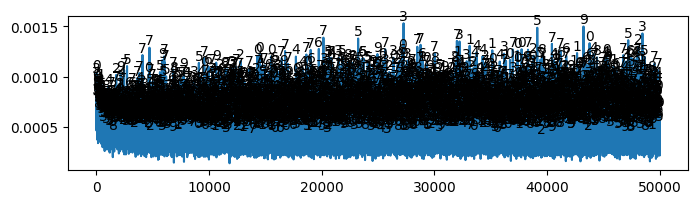

* Accuracy (Evidence: 11, iT: 1)


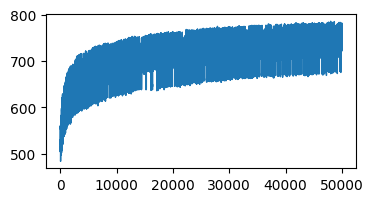

* Complexity (Evidence: 11, iT: 1)


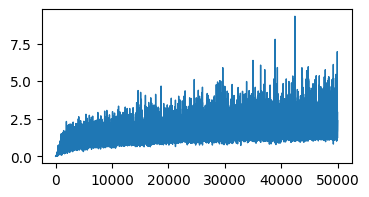

* VFE (Evidence: 11, iT: 1)


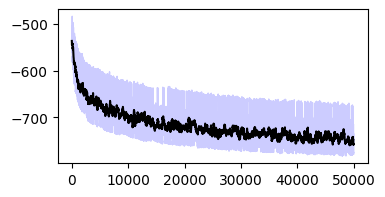

* Retrieval accuracy (Evidence: 11, iT: 1)


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


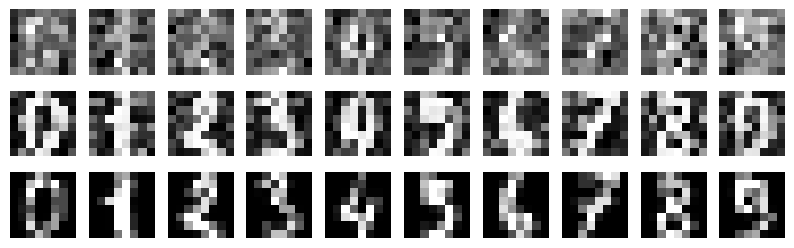

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


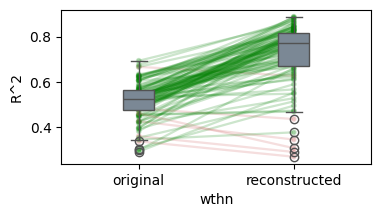

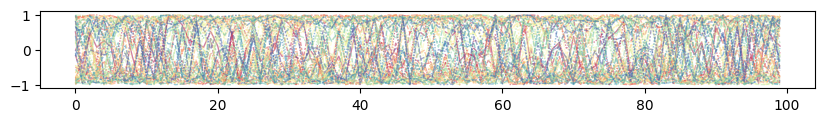

* Generalization accuracy (Evidence: 11, iT: 1)


100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


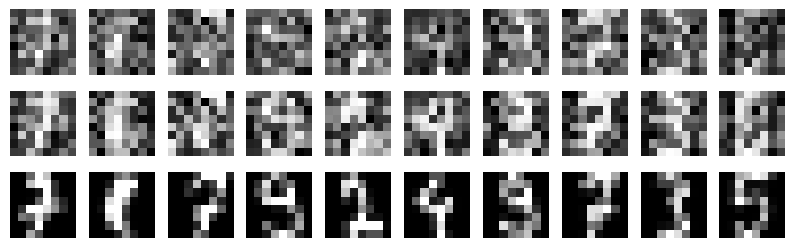

/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


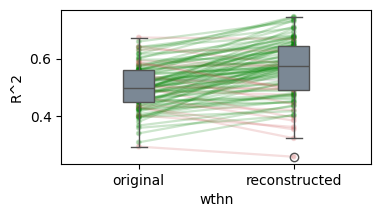

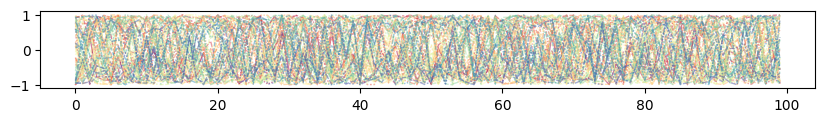

* Attractors
  ** Noise: 0.0


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


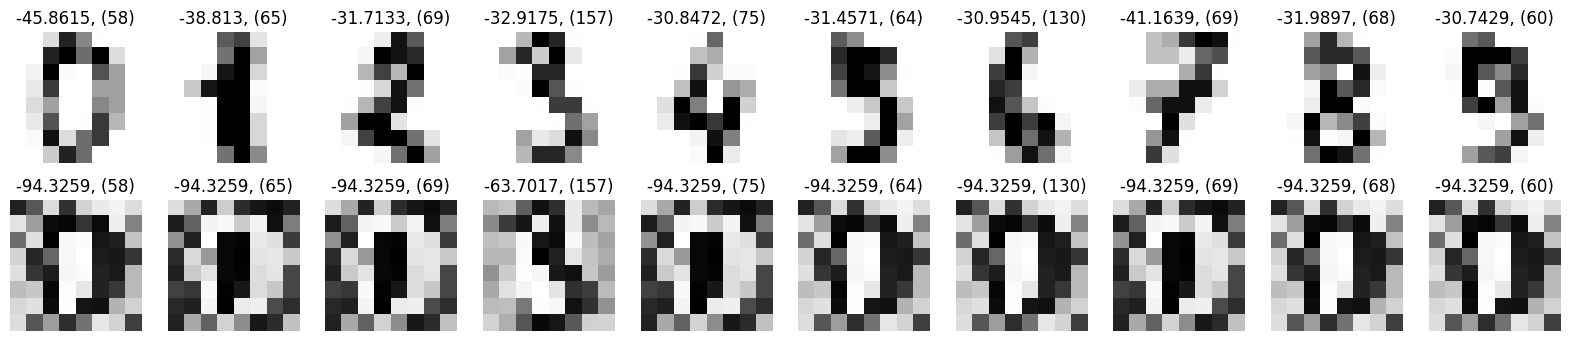

  ** Noise: 0.5


100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


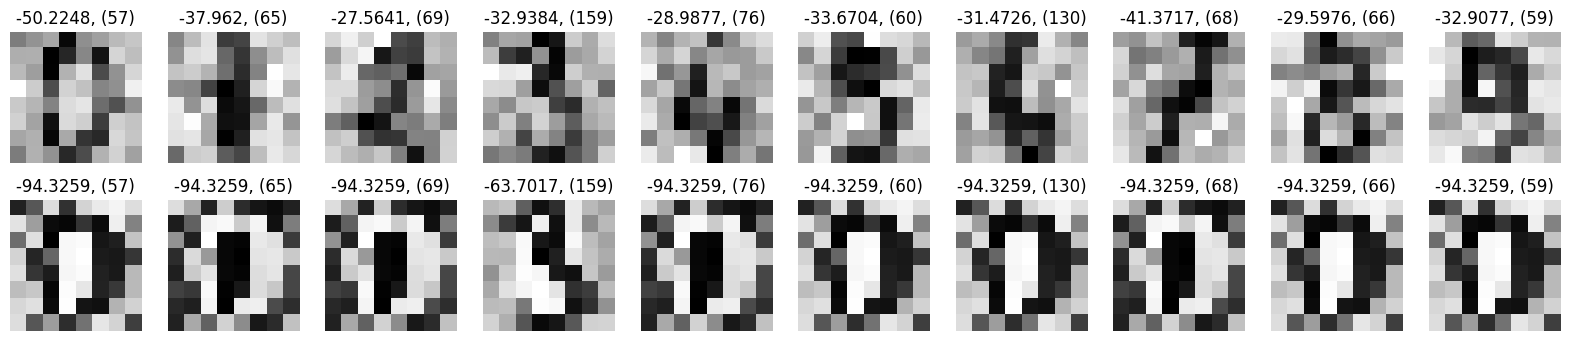

* Orthogonality


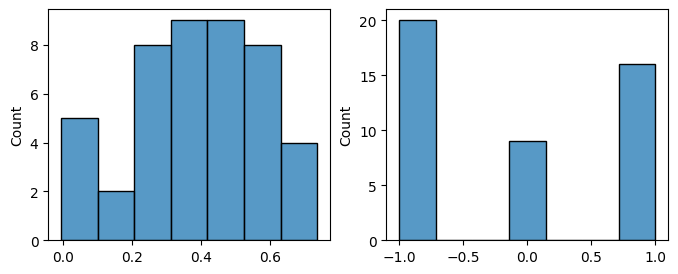

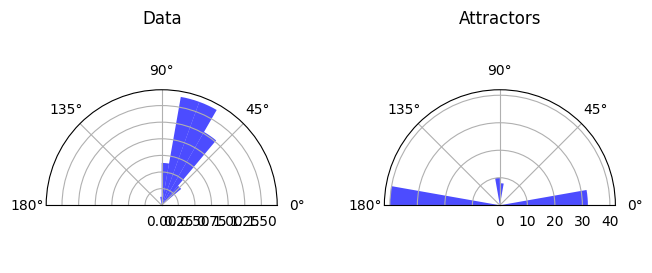

In [185]:
import importlib
import simulation.utils
importlib.reload(simulation.utils)
# Re-import the function needed in this cell after reloading the module
from simulation.utils import report_network_evaluation, get_deterministic_attractors


training_output_modified[0].set_J(nw.get_J())


report_network_evaluation(training_output_modified,
                          train_data=train_data,
                          test_data=test_data,
                          evidence_level=matching_entry['params']['evidence_level'],
                          params_retreival={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.1,
                                "SNR": 1,
                                "inverse_temperature": 1,
                          },
                          params_generalization={
                                "num_trials": 100,
                                "num_steps": 100,
                                "signal_strength": 0.2,
                                "SNR": 1,
                                "inverse_temperature": 0.5,
                          },
                          inverse_temperature_deterministic = 1,
                          title=f"Evidence: {evidence_level}, iT: {inverse_temperature}")

## Illustrate prior mixing for optimal parameters

{'params': {'evidence_level': np.float64(11.0), 'inverse_temperature': np.float64(0.16681005372000582)}, 'nw': <simulation.network.AttractorNetwork object at 0x61605c410>, 'median_delta_r2_retrieval': np.float64(0.292), 'median_delta_r2_generalization': np.float64(0.07), 'num_attractors': 10, 'orthogonality_data': np.float64(29.9374356124914), 'orthogonality_attractors': np.float64(17.34285659875748)}
  ** Noise: 0


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


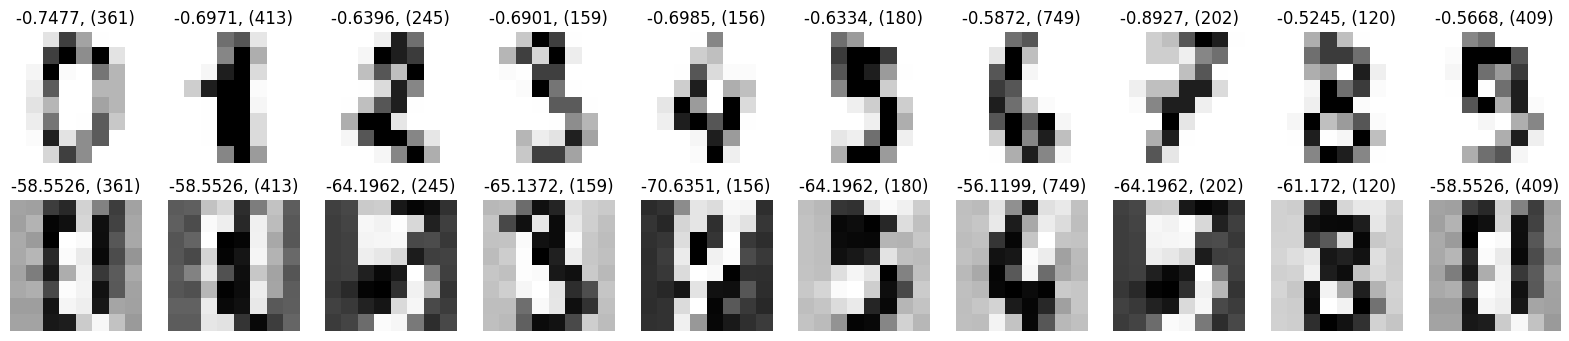

In [195]:
from simulation.utils import continous_inference_and_learning
from copy import deepcopy

evidence_level = 11
inverse_temperature = 0.1668

# Find the entry in performance_results that matches the specified evidence_level and inverse_temperature
matching_entry = None
for i, entry in enumerate(performance_results):
    # Use np.isclose for floating point comparison
    if np.isclose(entry['params']['evidence_level'], evidence_level, rtol=0.01) and \
       np.isclose(entry['params']['inverse_temperature'], inverse_temperature, rtol=0.01):
        matching_entry = entry
        break

print(matching_entry)

nw = deepcopy(matching_entry['nw'])

attractors = get_deterministic_attractors(nw=nw, data=train_data, noise_levels=[0], inverse_temperature=1)


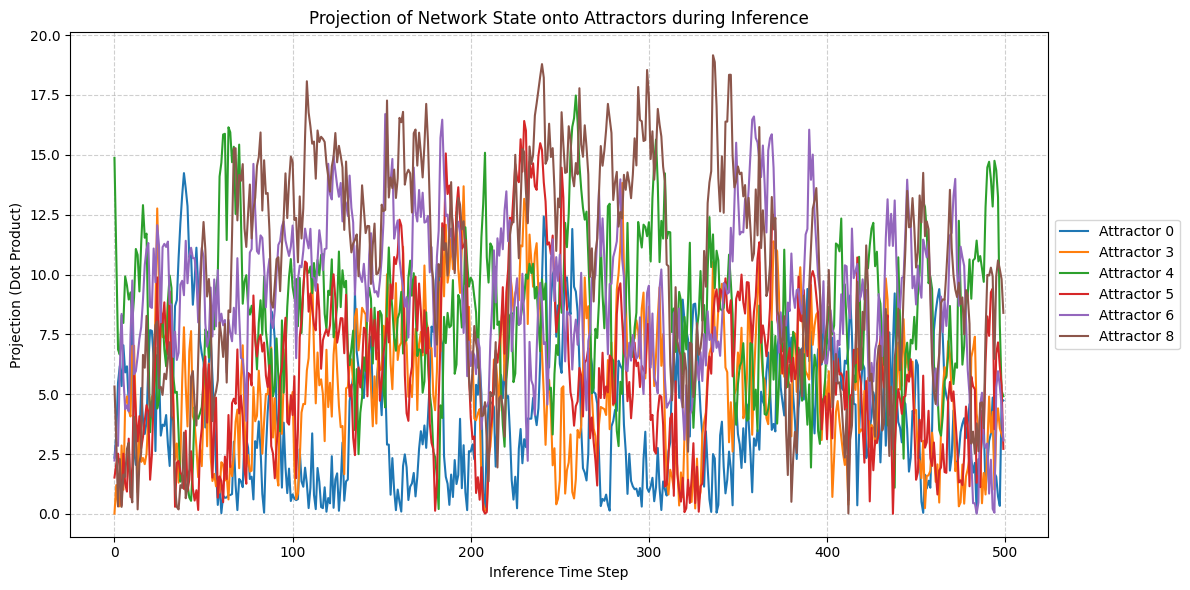

In [267]:
original_pattern = train_data[1] * matching_entry['params']['evidence_level'] * 0.01 + train_data[8] * matching_entry['params']['evidence_level'] * 0.01
SNR = 10
test_pattern = original_pattern #+ np.random.normal(0, original_pattern.std()/SNR, original_pattern.shape)
acts, _, _, _, _ = continous_inference_and_learning(nw, data=test_pattern, 
                                                            inverse_temperature=1, 
                                                            learning_rate=0.0, 
                                                            num_steps=500)
    
attractors_np = np.array(attractors) # Shape (num_attractors, num_nodes)

acts_np = np.array(acts) # Shape (num_steps, num_nodes)

num_steps_inference = acts_np.shape[0]
num_attractors = attractors_np.shape[0]
num_nodes = attractors_np.shape[1]

# Calculate projections
projections = np.zeros((num_attractors, num_steps_inference))

for t in range(num_steps_inference):
    current_activation = acts_np[t]
    # Project current activation onto each attractor
    projections[:, t] = np.abs(np.dot(attractors_np, current_activation))
    # Optional: Normalize if needed, e.g., by norm of attractors
    # norms_sq = np.sum(attractors_np**2, axis=1)
    # projections[:, t] = np.dot(attractors_np, current_activation) / norms_sq


# Plotting the projections over time
plt.figure(figsize=(12, 6))
for k in range(num_attractors):
    # Assuming attractors correspond to the order in train_data (digits 0-9)
    if k not in [1, 9, 2, 7]:
        plt.plot(projections[k, :], label=f'Attractor {k}') 

plt.xlabel("Inference Time Step")
plt.ylabel("Projection (Dot Product)")
plt.title("Projection of Network State onto Attractors during Inference")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Place legend outside
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [205]:
projections[0]

array([11.07295996, 11.79050192, 11.92940876, 13.24379279, 13.17783805,
       12.3454522 , 12.82104722, 13.0329005 , 13.11585291, 13.35182729,
       12.99522032, 12.3344223 , 12.11715087, 12.86306947, 12.87087498,
       12.6919725 , 13.04706312, 12.7647998 , 12.59438849, 12.19168989,
       12.62806896, 12.33343956, 12.55668055, 13.06516384, 12.45493464,
       11.53668655, 11.58024682, 12.88467253, 12.48516284, 12.32357303,
       11.55432775, 12.16416574, 12.62147931, 12.29524369, 11.8896689 ,
       11.96599542, 12.41253045, 13.19522437, 12.11558667, 12.24569931,
       12.49309644, 12.40793384, 12.16381489, 12.63514028, 12.19130571,
       12.57428103, 11.71380299, 12.18546481, 13.00860806, 11.60479004,
       11.90557557, 12.4880832 , 12.0962444 , 12.67668165, 12.48182828,
       13.19901918, 13.04590078, 11.46668727, 12.71393632, 12.97316032,
       12.16472214, 12.58711783, 11.97847742, 12.18840884, 12.49734536,
       12.64331556, 13.28885186, 12.22741376, 12.09161519, 12.02